<h1> Amazon Product Recommendations </h1>



In [1]:
#import all the necessary packages
import io
import requests
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

import math
import time
import re
import os

import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')
data.describe

<bound method NDFrame.describe of          sku        asin product_type_name formatted_price author  \
0       None  B016I2TS4W             SHIRT            None   None   
1       None  B01N49AI08             SHIRT            None   None   
2       None  B01JDPCOHO             SHIRT            None   None   
3       None  B01N19U5H5             SHIRT            None   None   
4       None  B004GSI2OS             SHIRT          $26.26   None   
...      ...         ...               ...             ...    ...   
183133  None  B01MSALTSO         OUTERWEAR          $14.58   None   
183134  None  B015W98YQK             SHIRT            None   None   
183135  None  B075756PGC             SHIRT            None   None   
183136  None  B074L8FVTT             SHIRT          $44.99   None   
183137  None  B074FTYJQC             SHIRT            None   None   

                    color          brand      publisher  \
0                    None          FNC7C           None   
1                  

In [3]:
print (f'Number of data points : {data.shape[0]} \nNumber of features/variables: {data.shape[1]}')

Number of data points : 183138 
Number of features/variables: 19


In [4]:
# prints column-names or feature-names.
data.columns 

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [5]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [6]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() 

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


## Missing data for various features.

### For product_type_name

In [7]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [8]:
#10 most frequent product_type_names
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

###  For Brand

In [9]:
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [10]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

### For color

In [11]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [12]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

### For formatted_price

In [13]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [14]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

### For title


In [15]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [16]:
# Check point, Saving data
data.to_pickle('pickels/180k_data')

## Removing NULL Items

In [17]:
# consider products which have price information
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [18]:
# consider products which have color information
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [19]:
#Check point, Saving data
data.to_pickle('pickels/28k_data')

## Removing duplicate items

### Understand about duplicates.

In [20]:
# read data from pickle file
data = pd.read_pickle('pickels/28k_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))

2325


### In our data there are many duplicate products, we need to de-dupe them for better results.


### Remove duplicates

In [21]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_data')

In [22]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [23]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [24]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


### Some examples of dupliacte titles that differ only in the last few words.

In [25]:
data_sorted.title

61973     Éclair Women's Printed Thin Strap Blouse Black...
133820    xiaoming Womens Sleeveless Loose Long T-shirts...
81461     xiaoming Women's White Long Sleeve Single Brea...
75995     xiaoming Stripes Tank Patch/Bear Sleeve Anchor...
151570    xiaoming Sleeve Sheer Loose Tassel Kimono Woma...
                                ...                        
12050     "Life is a Journey" Self-Help DIY T-Shirt (Wom...
40451     "I Workout To Burn off The Crazy", Tri Blend T...
109599    "I Wanna Be Adored" Long Sleeve Top with Shred...
78827            "Camisoles Grey - Medium Fair Labor, 1 pc"
118987    "1984" Retro Book Cover Women's SLim Fit T-Shi...
Name: title, Length: 27949, dtype: object

In [26]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [27]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]

while i < num_data_points and j < num_data_points:  
    previous_i = i
    a = data['title'].loc[indices[i]].split()
    
    j = i+1
    while j < num_data_points:
        b = data['title'].loc[indices[j]].split()

        length = max(len(a), len(b))

        # count to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        
        # number of words in which both sensences differ
        if (length - count) > 2: 
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [28]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

### Removing  the dupliactes which differ at the end

In [29]:
print('Number of data points : ', data.shape[0])

Number of data points :  17592


In [30]:
data.to_pickle('pickels/17k_data')

# Text pre-processing

In [31]:
data = pd.read_pickle('pickels/17k_data')

In [32]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ("".join(e for e in words if e.isalnum()))
            word = word.lower()
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [33]:
# we take each title and we text-preprocess it
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

In [34]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


In [35]:
data.to_pickle('pickels/17k_data_preprocessed')

### Stemming 

In [36]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

### Text based product similarity

In [37]:
data = pd.read_pickle('pickels/17k_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


In [38]:
#Display an image
def display_img(url,ax,fig):
    response = requests.get(url,  verify=False)
    img = Image.open(io.BytesIO(response.content))
    plt.imshow(img)

In [39]:
#plotting 
def plot_heatmap(keys, values, labels, url, text):

        # dividing the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])        
        # it displays a cell in white color if the word is intersection
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys)
        ax.set_title(text)
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        #call dispaly_img 
        display_img(url, ax, fig)
        
        # displays combine figure
        plt.show()

In [40]:
#plot for heatmap image
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # finding the common words in both titles
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # set the values of non intersecting words to zero
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)

In [41]:
#text to vector
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 

In [42]:
def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Method 1: Bag of Words (BoW) on product titles.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(17592, 12927)

In [44]:
def bag_of_words_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*125)

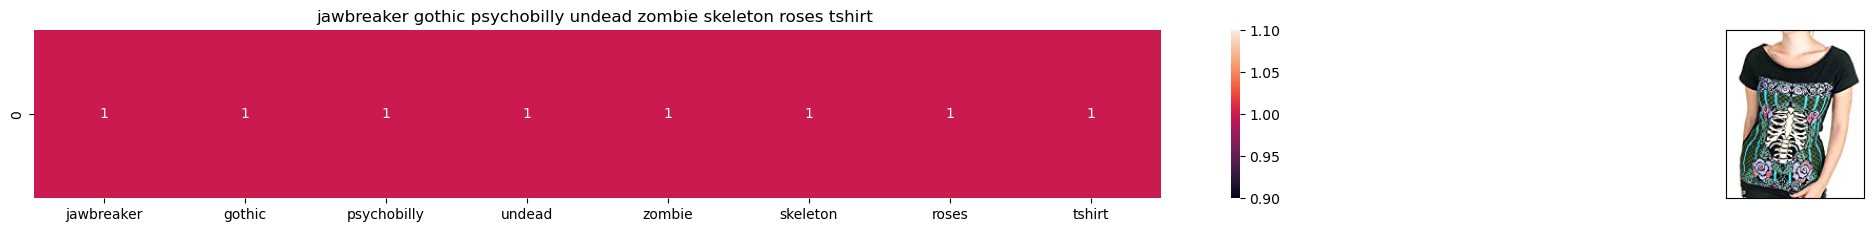

ASIN : B01D3R5VXC
Brand: Jawbreaker
Title: jawbreaker gothic psychobilly undead zombie skeleton roses tshirt 
Euclidean similarity with the query image : 0.0


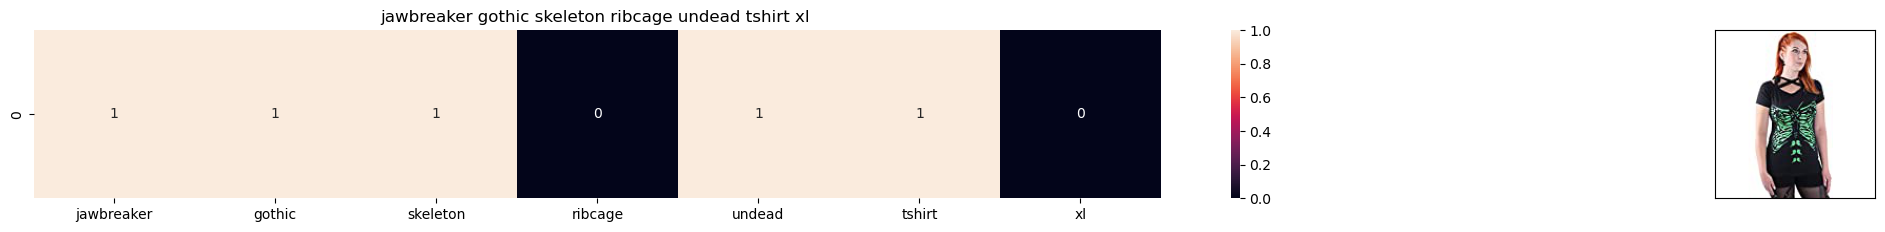

ASIN : B072YV132Q
Brand: Jawbreaker
Title: jawbreaker gothic skeleton ribcage undead tshirt xl 
Euclidean similarity with the query image : 2.23606797749979


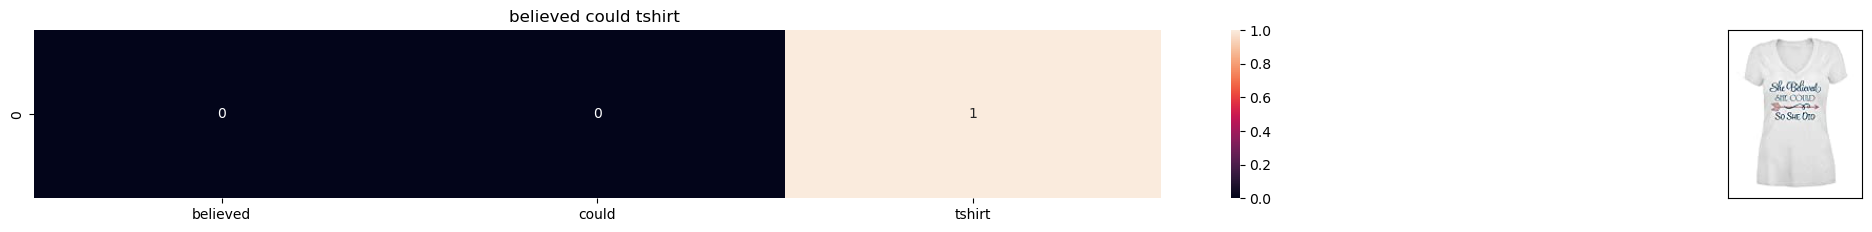

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


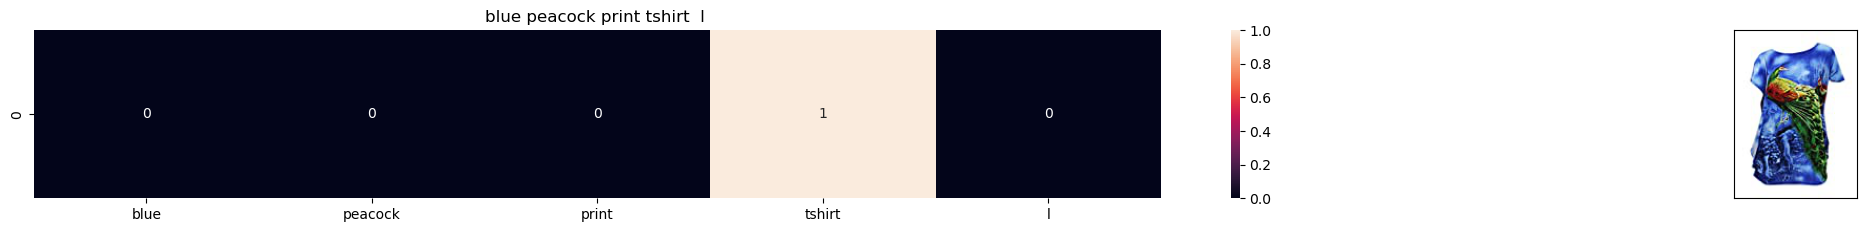

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.1622776601683795


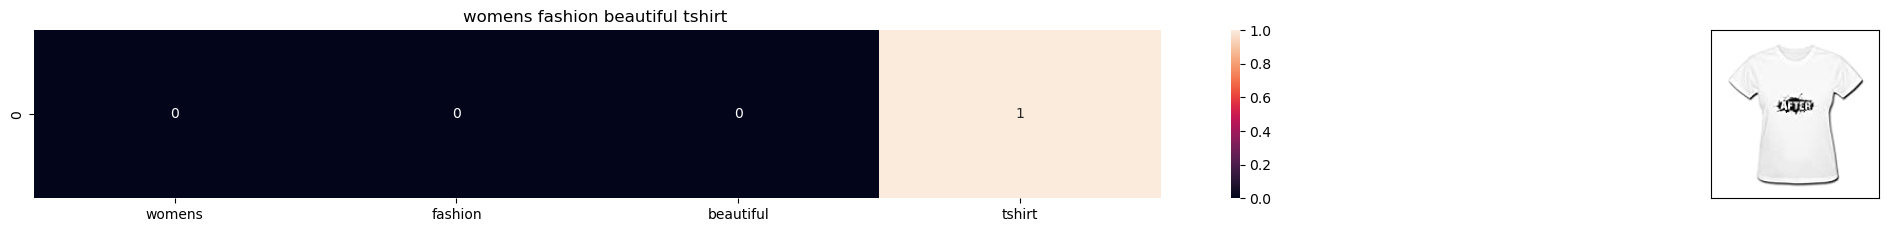

ASIN : B074VMNZN9
Brand: simple
Title: womens fashion beautiful tshirt 
Euclidean similarity with the query image : 3.1622776601683795


In [45]:
# Choosing a random item which is at place 12566, and finding 5 similar items to that 
bag_of_words_model(12566, 5)

##  Method 2: TF-IDF based product similarity

In [46]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

In [47]:
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)

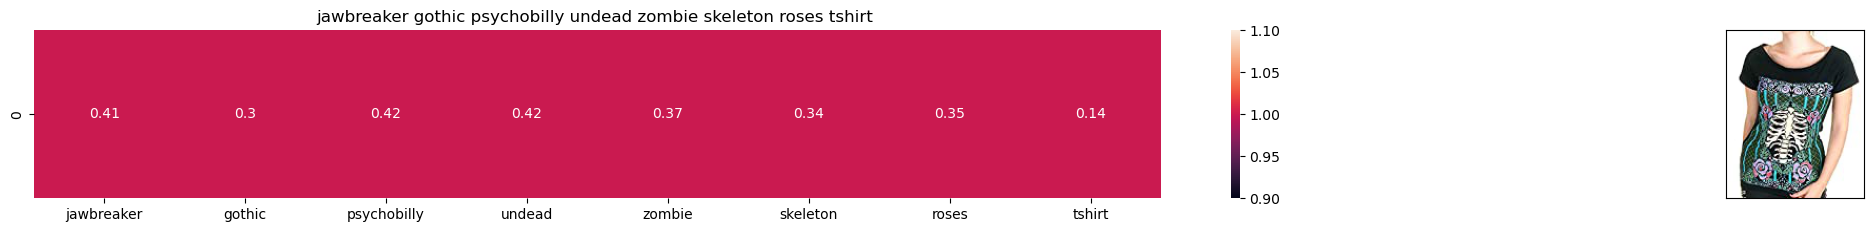

ASIN : B01D3R5VXC
BRAND : Jawbreaker
Eucliden distance from the given image : 0.0


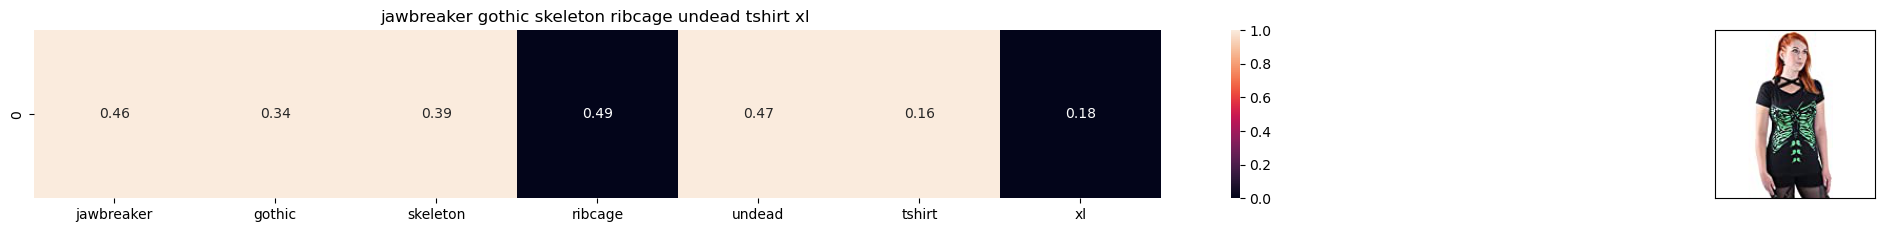

ASIN : B072YV132Q
BRAND : Jawbreaker
Eucliden distance from the given image : 0.8500464188614657


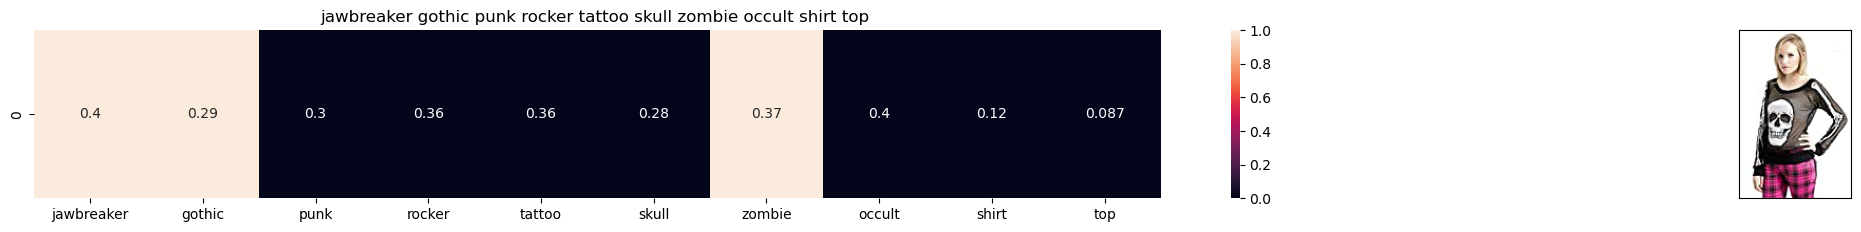

ASIN : B06XTY8ZK5
BRAND : Jawbreaker
Eucliden distance from the given image : 1.1067170509782724


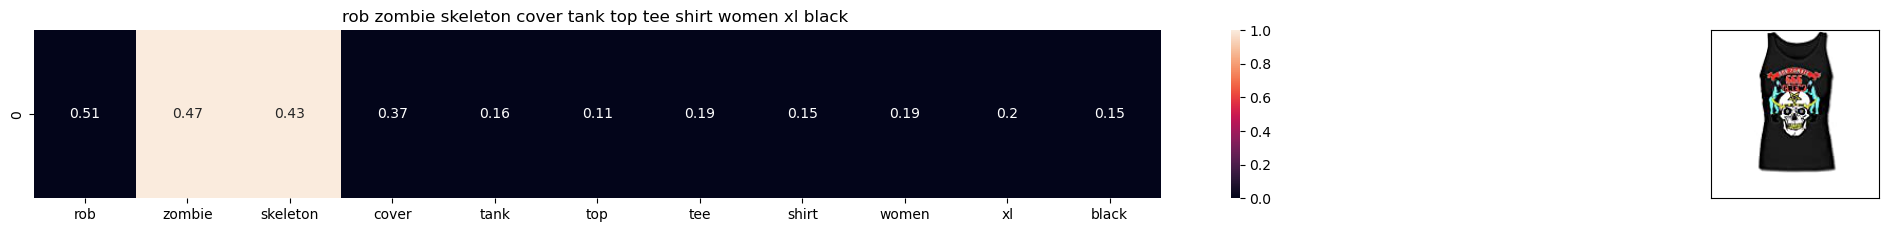

ASIN : B01HJ8S7ZU
BRAND : WOKE
Eucliden distance from the given image : 1.166128697641244


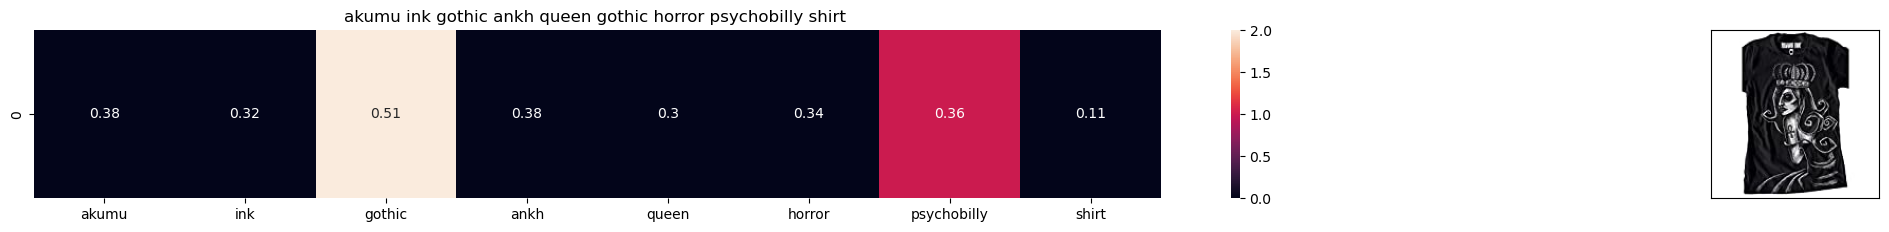

ASIN : B01EO0HMAC
BRAND : Akumu Ink
Eucliden distance from the given image : 1.1790884176738445


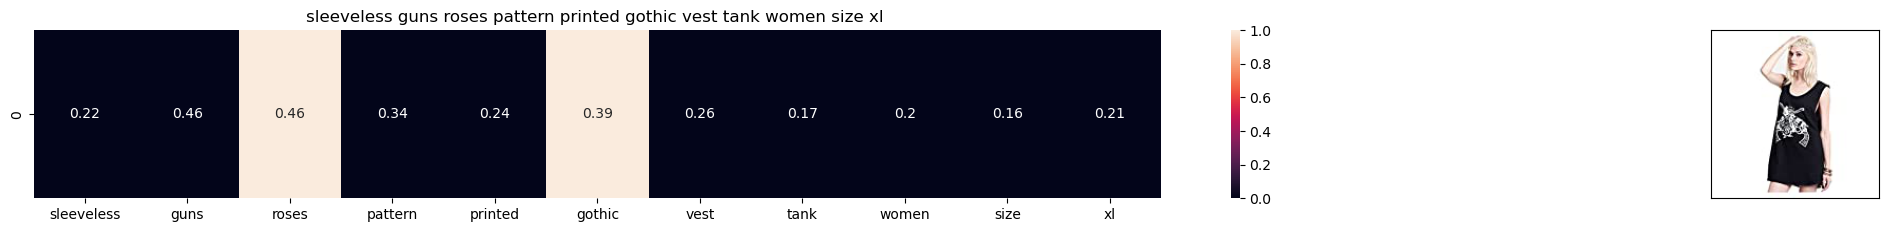

ASIN : B00PLYB1UI
BRAND : namnoishop Crop Tops
Eucliden distance from the given image : 1.2021082631244282


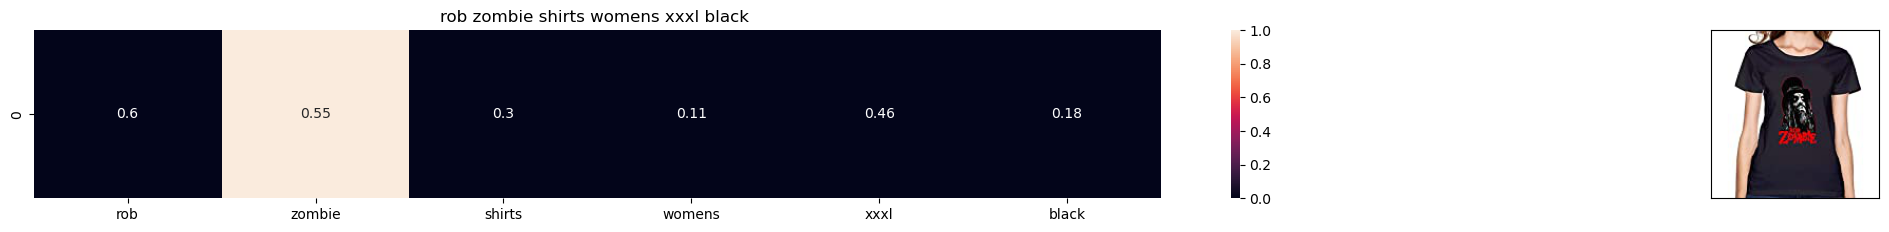

ASIN : B01KFGQ700
BRAND : MajinaHerrera
Eucliden distance from the given image : 1.262814698590633


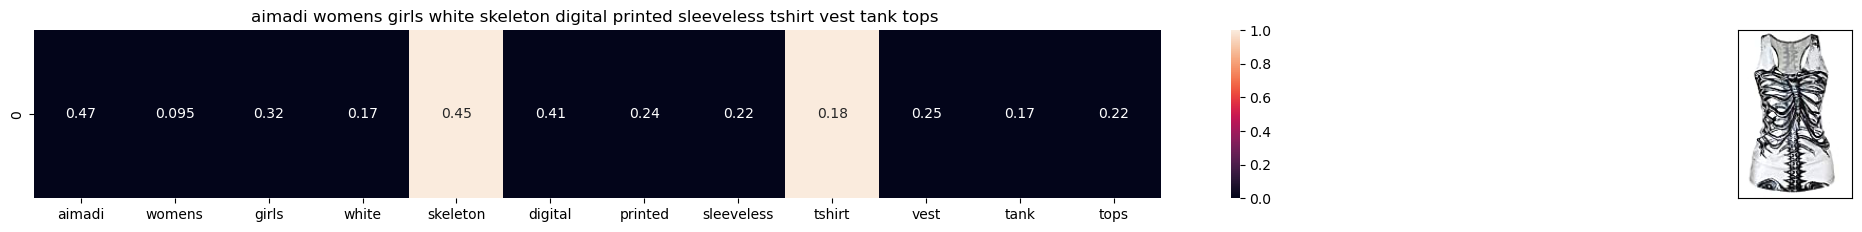

ASIN : B00UCVV05Q
BRAND : Aimadi
Eucliden distance from the given image : 1.2823204604626426


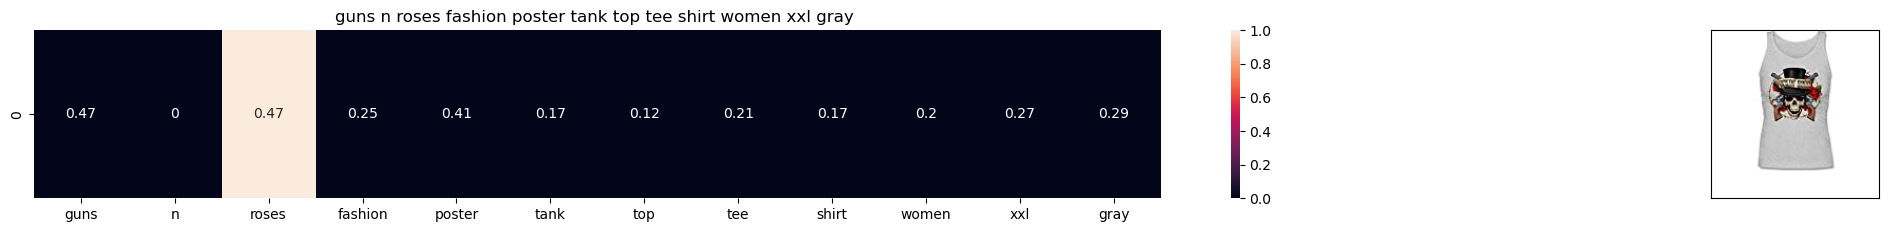

ASIN : B01IOGYV0G
BRAND : WOKE
Eucliden distance from the given image : 1.291659855978654


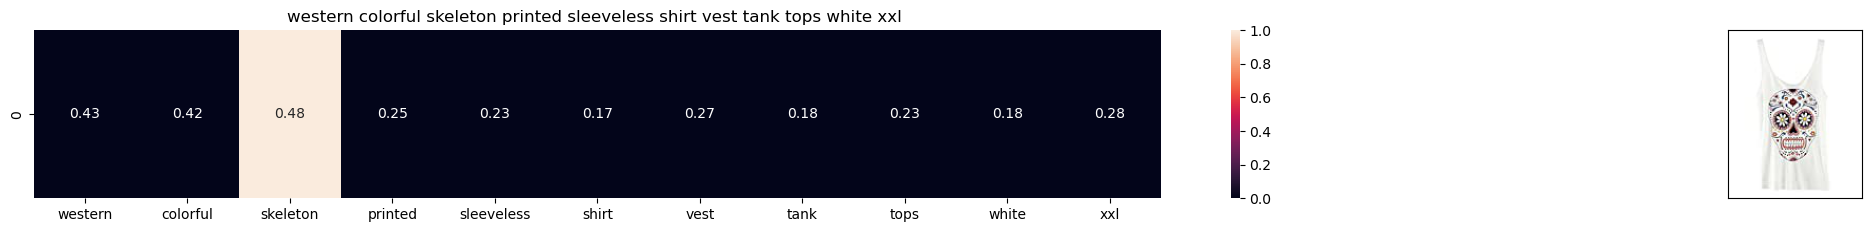

ASIN : B00Z6HFHEG
BRAND : Black Temptation
Eucliden distance from the given image : 1.2943074479187184


In [48]:
# Choosing a random item which is at place 12566, and finding 10 similar items to that 
tfidf_model(12566, 10)

# Method 3: Visual features based product similarity

In [49]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [50]:
# this block takes hours to run, so have runed it onces and stores the file to use in latter stages
# What this block do is just convertes the each image into to D dimensional vector

''' 
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

'''

" \n# dimensions of our images.\nimg_width, img_height = 224, 224\n\ntop_model_weights_path = 'bottleneck_fc_model.h5'\ntrain_data_dir = 'images2/'\nnb_train_samples = 16042\nepochs = 50\nbatch_size = 1\n\n\ndef save_bottlebeck_features():\n    \n    asins = []\n    datagen = ImageDataGenerator(rescale=1. / 255)\n    \n    # build the VGG16 network\n    model = applications.VGG16(include_top=False, weights='imagenet')\n    generator = datagen.flow_from_directory(\n        train_data_dir,\n        target_size=(img_width, img_height),\n        batch_size=batch_size,\n        class_mode=None,\n        shuffle=False)\n\n    for i in generator.filenames:\n        asins.append(i[2:-5])\n\n    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)\n    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))\n    \n    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)\n    np.save(open('16k_data_cnn_feature_

In [51]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/17k_data_preprocessed')
df_asins = list(data['asin'])

In [52]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

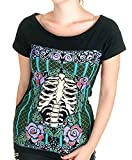

Product Title:  jawbreaker gothic psychobilly undead zombie skeleton roses tshirt 
Euclidean Distance from input image: 7.6293945e-06
Amazon Url: www.amzon.com/dp/B01D3R5VXC


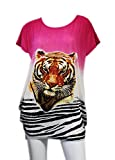

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 54.63879
Amazon Url: www.amzon.com/dp/B00JXQASS6


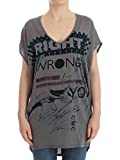

Product Title:  costume national gray vneck long tshirt 
Euclidean Distance from input image: 56.87912
Amazon Url: www.amzon.com/dp/B074G5MLT7


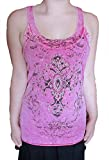

Product Title:  vocal apparel womens tee shirt tunic tank small distressed pink 
Euclidean Distance from input image: 57.099716
Amazon Url: www.amzon.com/dp/B00Z1XBX3Y


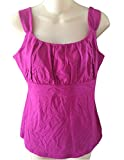

Product Title:  ann taylor womens dark carnation pink top mp 
Euclidean Distance from input image: 57.38179
Amazon Url: www.amzon.com/dp/B01GQJN302


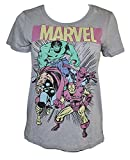

Product Title:  marvel comics avengers juniors scoop neck tee shirt xs light gray 
Euclidean Distance from input image: 57.515606
Amazon Url: www.amzon.com/dp/B0735HXWT2


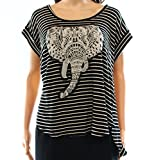

Product Title:  le lis womens medium embroidered crochet seamed blouse black 
Euclidean Distance from input image: 57.556404
Amazon Url: www.amzon.com/dp/B07355MQK1


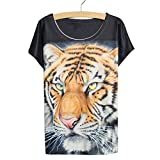

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 58.05583
Amazon Url: www.amzon.com/dp/B010NN9RXO


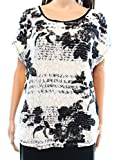

Product Title:  vanilla sugar black womens medium floral print blouse white 
Euclidean Distance from input image: 58.2281
Amazon Url: www.amzon.com/dp/B072K3CZW6


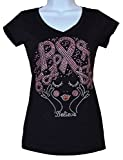

Product Title:  rhinestone breast cancer ribbon first step top shirt cure shirt size 3xl xxl 19 x 29 
Euclidean Distance from input image: 58.291897
Amazon Url: www.amzon.com/dp/B010VZ08UA


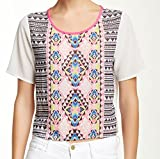

Product Title:  love hanger geometric printed medium junior blouse white 
Euclidean Distance from input image: 58.311047
Amazon Url: www.amzon.com/dp/B01HOCVVRM


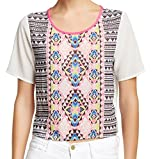

Product Title:  love hanger pink junior printed chiffon blouse white xs 
Euclidean Distance from input image: 58.343285
Amazon Url: www.amzon.com/dp/B01IPTVWUY


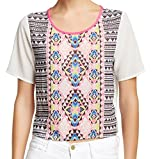

Product Title:  love hanger pink womens large print chiffon blouse white l 
Euclidean Distance from input image: 58.343285
Amazon Url: www.amzon.com/dp/B01L0OTNIO


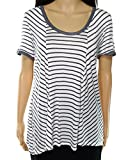

Product Title:  dkny womens small striped scoopnec tee tshirt white 
Euclidean Distance from input image: 58.435284
Amazon Url: www.amzon.com/dp/B0725PWQFW


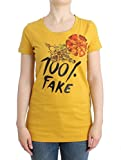

Product Title:  moschino yellow tshirt short sleeved top blouse 
Euclidean Distance from input image: 58.43899
Amazon Url: www.amzon.com/dp/B074G4VFHW


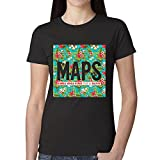

Product Title:  maroon 5 maps rumba whoa remix women tshirt black 
Euclidean Distance from input image: 58.456352
Amazon Url: www.amzon.com/dp/B01HAU12EA


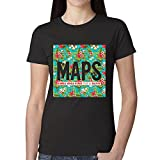

Product Title:  maroon 5 maps rumba whoa remix shirt women black 
Euclidean Distance from input image: 58.456352
Amazon Url: www.amzon.com/dp/B01HAU17U4


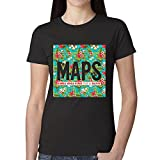

Product Title:  maroon 5 maps rumba whoa remix shirts women black 
Euclidean Distance from input image: 58.456352
Amazon Url: www.amzon.com/dp/B01HAU1EDE


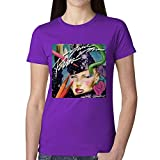

Product Title:  grace jones fame women tshirt purple 
Euclidean Distance from input image: 58.59835
Amazon Url: www.amzon.com/dp/B01GXAZNVG


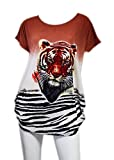

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 58.650585
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


In [53]:
# Choosing a random item which is at place 12566, and finding 10 similar items to that 
get_similar_products_cnn(12566, 20)